**Beyond sporadic outbreaks: Classifying and explaining dengue endemicity over scenarios of global change.**

*CPSC 581: Machine Learning*

*Yale University*

*Instructor: Alex Wong*

*Student: Hailey Robertson*

#### Import packages

In [62]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import font_manager
import seaborn as sns
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPolygon 
from shapely.geometry.base import BaseGeometry 
import country_converter as coco
import warnings
import os
import json
import xarray as xr
import regionmask

warnings.filterwarnings(action='ignore')
np.random.seed(42)

#### Nice defaults for plotting

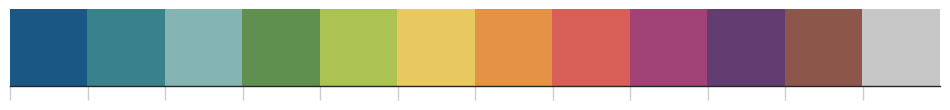

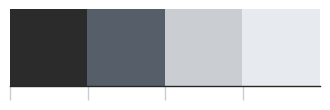

In [63]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Create data

#### Load Open Dengue and align country names

In [117]:
# --- Load dengue data ---
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
open_dengue = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

open_dengue["adm_0_iso3"] = coco.convert(
    names=open_dengue["adm_0_name"],
    to='ISO3',
    not_found="missing"
)

date_cols = ['calendar_start_date', 'calendar_end_date']
open_dengue[date_cols] = open_dengue[date_cols].apply(pd.to_datetime)
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year
open_dengue['month'] = open_dengue['calendar_start_date'].dt.month

#  Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# Find geo resolution and combine places
def highest_geo_resolution(row):
    if pd.notna(row['adm_2_name']) and row['adm_2_name'] != '':
        return 'adm_2'
    elif pd.notna(row['adm_1_name']) and row['adm_1_name'] != '':
        return 'adm_1'
    else:
        return 'adm_0'

open_dengue['geo_resolution'] = open_dengue.apply(highest_geo_resolution, axis=1)

open_dengue['combined_place'] = open_dengue[['adm_2_name', 'adm_1_name', 'adm_0_name']].apply(
    lambda x: ', '.join([str(place) for place in x if pd.notna(place) and place != '']), axis=1)

# --- Load world geometry ---
world = gpd.read_file("../data/ne_110m_admin_0_countries")

world = world.rename(columns={
    "ADM0_A3": "adm_0_iso3",
    "ADMIN": "adm_0_name",
    "REGION_UN": "region_un",
    "geometry": "adm_0_geometry"
})[["adm_0_iso3", "adm_0_name", "region_un", "adm_0_geometry"]]

world = world.sort_values(by="adm_0_name")

# --- Fix known issues ---
# Split out French Guiana from France
france_idx = world['adm_0_name'] == 'France'
france_geom = world.loc[france_idx, 'adm_0_geometry'].values[0]

if isinstance(france_geom, MultiPolygon):
    polygons = list(france_geom.geoms)
    french_guiana_polygon = next((poly for poly in polygons if poly.bounds[0] < -50 and poly.bounds[2] > -54), None)

    if french_guiana_polygon:
        # Remove French Guiana from France
        remaining_polygons = [poly for poly in polygons if poly != french_guiana_polygon]
        world.loc[france_idx, 'adm_0_geometry'] = MultiPolygon(remaining_polygons)

        # Add French Guiana as separate entry
        french_guiana_row = {
            'adm_0_iso3': 'GUF',
            'adm_0_name': 'French Guiana',
            'region_un': 'Americas',
            'adm_0_geometry': french_guiana_polygon
        }
        world = pd.concat([world, gpd.GeoDataFrame([french_guiana_row], geometry='adm_0_geometry')], ignore_index=True)

# Patch ISO3 codes for special cases
world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'
world.loc[world['adm_0_name'] == 'South Sudan', 'adm_0_iso3'] = 'SSD'

# --- Merge dengue data with geometry ---
dengue = pd.merge(open_dengue, world, on='adm_0_iso3', how='outer', suffixes=('', '_world'))

# Fill UN regions with mapping
with open('../data/un_regions.json') as f:
    countries = json.load(f)
dengue['region_un'] = dengue['adm_0_iso3'].map(countries).fillna("Other")

# Aesthetics
dengue = dengue.drop(columns=['adm_0_name_world'])
front_cols = ['adm_0_name', 'adm_0_iso3']
geometry_col = ['adm_0_geometry']
other_cols = [col for col in dengue.columns if col not in front_cols + geometry_col]
dengue = dengue[front_cols + other_cols + geometry_col]

# Fill the years so that ISO3s stay as a time series
years = pd.Series(range(int(1950), int(dengue['year'].max()) + 1))
unique_iso3 = dengue['adm_0_iso3'].unique()

all_combinations = pd.MultiIndex.from_product([unique_iso3, years], names=['adm_0_iso3', 'year']).to_frame(index=False)

dengue_ts = all_combinations.merge(dengue, on=['adm_0_iso3', 'year'], how='outer')

# List of columns to fill
columns_to_fill = ['adm_0_name', 'region_un', 'adm_0_geometry', 'geo_resolution', 'combined_place']

# Fill NaN values for multiple columns
dengue_ts[columns_to_fill] = (
    dengue_ts
    .groupby('adm_0_iso3')[columns_to_fill]
    .transform(lambda x: x.ffill().bfill())
)

dengue_ts = dengue_ts.dropna(subset=['year'])

#### Load other predictors

In [118]:
# --- Clean population data ---
pop = pd.read_csv("../data/WPP2022_Demographic_Indicators_Medium.csv", dtype={'Time': int,'TPopulation1July':float}, low_memory=False)
columns = ['ISO3_code','Time','TPopulation1July']
pop = pop[columns]
pop.rename(columns={"ISO3_code": "adm_0_iso3", "Time": "year", "TPopulation1July": "TPopulation1July_per_1000"}, inplace=True)

# --- Clean population density ---
pop_dns = pd.read_csv("../data/pop_density_wb.csv")
year_cols = [col for col in pop_dns.columns if col.isdigit()]
pop_dns = pop_dns.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="pop_density_per_km2"
)
pop_dns.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)

# --- Clean climate data ---
clim = ['era5_tnn_annual_min_temp.csv', 'era5_tas_annual_mean_temp.csv', 'era5_pr_annual_mean_precipitation.csv', 'era5_hur_annual_mean_relative_humidity.csv']

climate_df = {}

for file in clim:
    data = pd.read_csv(f"../data/{file}")
    
    year_cols = [col for col in data.columns if col.startswith('19') or col.startswith('20')]

    melted = data.melt(
        id_vars=["code"],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )

    melted["year"] = melted["year"].str.extract(r"(\d{4})")
    melted.rename(columns={"code": "adm_0_iso3"}, inplace=True)
    indicator = file.replace('.csv', '')  
    melted.rename(columns={"value": indicator}, inplace=True)
    climate_df[indicator] = melted

# --- Clean urbanization data ---
urban = pd.read_csv("../data/urban_growth_wb.csv")

year_cols = [col for col in urban.columns if col.startswith('19') or col.startswith('20')]

urban = urban.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="urban_growth"
)
urban.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
urban['year'] = urban['year'].str.extract(r"(\d{4})")

# --- Clean GDP data ---
gdp = pd.read_csv("../data/gdp_ppp_wb.csv")

year_cols = [col for col in gdp.columns if col.startswith('19') or col.startswith('20')]

gdp = gdp.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="gdp_ppp"
)
gdp.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
gdp['year'] = gdp['year'].str.extract(r"(\d{4})")

# --- Clean arrivals data ---
arr = pd.read_csv("../data/tourism_arrivals_wb.csv")

year_cols = [col for col in arr.columns if col.startswith('19') or col.startswith('20')]

arr = arr.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="tourism_arrivals"
)
arr.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
arr['year'] = arr['year'].str.extract(r"(\d{4})")

# --- Clean departures data ---
dep = pd.read_csv("../data/tourism_departures_wb.csv")

year_cols = [col for col in dep.columns if col.startswith('19') or col.startswith('20')]

dep = dep.melt(
    id_vars=["Country Code"],
    value_vars=year_cols,
    var_name="year",
    value_name="tourism_departures"
)
dep.rename(columns={"Country Code": "adm_0_iso3"}, inplace=True)
dep['year'] = dep['year'].str.extract(r"(\d{4})")

In [123]:
predictor_dfs = [pop, 
                 pop_dns, 
                 climate_df['era5_hur_annual_mean_relative_humidity'],
                 climate_df['era5_pr_annual_mean_precipitation'],
                 climate_df['era5_tas_annual_mean_temp'],
                 climate_df['era5_tnn_annual_min_temp'],
                 urban,
                 gdp,
                 arr,
                 dep]

merged_df = dengue_ts.copy()

for i, predictor in enumerate(predictor_dfs):
    predictor['year'] = pd.to_numeric(predictor['year'], errors='coerce').astype('Int64')
    merged_df = merged_df.merge(predictor, how='outer', on=['adm_0_iso3', 'year'])

#### Calculate incidence rates - get to clean dataset!

In [ ]:
grouped_df = merged_df.groupby(['adm_0_iso3', 
                                'year',
                                'region_un',
                                'TPopulation1July_per_1000']).agg({
    'dengue_total': 'sum'
}).reset_index()

grouped_df['TPopulation1July'] = grouped_df['TPopulation1July_per_1000'] * 1000
grouped_df['incidence'] = grouped_df['dengue_total'] / grouped_df['TPopulation1July']
grouped_df['incidence_per_100k'] = grouped_df['incidence'] * 100000
grouped_df['log_incidence_per_100k'] = np.log1p(grouped_df['incidence_per_100k'])  # log(x + 1) to handle zero values

KeyError: 'TPopulation1July_per_1000'

In [ ]:
grouped_df

In [115]:
##  NOTE: Start here if you don't want to run all of the above :) 
# grouped_df.to_csv('../output/data/cleaned_master_df.csv', index=False)

# --- Load cleaned data ---
df = pd.read_csv('../output/data/cleaned_master_df.csv')
print(df.columns)
print(df.shape)

Index(['adm_0_iso3', 'year', 'region_un', 'TPopulation1July_per_1000',
       'pop_density_per_km2', 'era5_hur_annual_mean_relative_humidity',
       'era5_pr_annual_mean_precipitation', 'era5_tas_annual_mean_temp',
       'era5_tnn_annual_min_temp', 'urban_growth', 'gdp_ppp',
       'tourism_arrivals', 'tourism_departures', 'dengue_total',
       'TPopulation1July', 'incidence', 'incidence_per_100k',
       'log_incidence_per_100k'],
      dtype='object')
(11140, 18)


##### View data coverage

In [ ]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
heatmap_data = df.pivot(index='adm_0_iso3', columns='year', values='incidence_per_100k').fillna(0)
print(len(heatmap_data))
rocket_r_cmap = sns.color_palette("rocket_r", as_cmap=True)
custom_cmap = ListedColormap(["white"] + list(rocket_r_cmap(np.linspace(0.01, 1, 1000))))

# Plot
fig, ax = plt.subplots(figsize=(14, 35))  # Adjust size as needed

custom_colors = ["white", colors[1]]


# Plot the heatmap
im = sns.heatmap(data=heatmap_data, 
                 cmap=custom_cmap, 
                 annot=False, 
                 fmt='g', 
                 linewidths=0.1, 
                 ax=ax, 
                 vmin=0, 
                 vmax=1000, 
                 cbar=True, 
                 cbar_kws={'orientation': 'horizontal', 'pad': 0.02, 'label':'Incidence rate per 100,000'})

# Set tick labels and axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title("Incidence rate per 100,000 over time",loc='left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=10)
plt.setp(ax.get_xticklabels(), rotation=45)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10, rotation=0)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
filename = f"../output/figures/open_dengue_incidence_1950-2023_full_covg.png"
plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
plt.close()

200


## Aim 1: Classify countries by endemicity status

In [ ]:
# Find unique countries that have ever had incidence > 0
countries_with_incidence = df[df['incidence'] > 0]['adm_0_iso3'].unique()

# Filter the DataFrame to include only rows for these countries
any_dengue = df[df['adm_0_iso3'].isin(countries_with_incidence)]
any_dengue.sort_values(by=["adm_0_iso3", "year"], ascending=[True, True], inplace=True)

any_dengue_list = any_dengue.adm_0_iso3.unique()
print(len(any_dengue.adm_0_iso3.unique()))
print(any_dengue.adm_0_iso3.unique())

89
['ABW' 'AFG' 'ARG' 'ASM' 'ATG' 'AUS' 'BGD' 'BHS' 'BLZ' 'BMU' 'BOL' 'BRA'
 'BRB' 'BRN' 'BTN' 'CHL' 'CHN' 'COL' 'CRI' 'CUB' 'CUW' 'CYM' 'DMA' 'DOM'
 'ECU' 'FJI' 'FSM' 'GRD' 'GTM' 'GUM' 'GUY' 'HKG' 'HND' 'HTI' 'IDN' 'IND'
 'JAM' 'JPN' 'KHM' 'KIR' 'KNA' 'LAO' 'LCA' 'LKA' 'MAC' 'MAF' 'MDV' 'MEX'
 'MHL' 'MMR' 'MNG' 'MNP' 'MYS' 'NCL' 'NIC' 'NPL' 'NRU' 'PAK' 'PAN' 'PER'
 'PHL' 'PLW' 'PNG' 'PRI' 'PRY' 'PYF' 'SAU' 'SDN' 'SGP' 'SLB' 'SLV' 'SUR'
 'SXM' 'TCA' 'THA' 'TLS' 'TON' 'TTO' 'TUV' 'URY' 'USA' 'VCT' 'VEN' 'VGB'
 'VIR' 'VNM' 'VUT' 'WSM' 'YEM']


## Aim 2: Use explainable AI to interpret predictions